# OCSVM Baseline Model
*Created by Holger Buech, Q1/2019*

**Description**   

Reimplemenation of a OCSVM approach to Continuous Authentication described by [1]. Used as baseline model for futher experiments.

**Purpose**

- Get basic idea about authentication performance using raw data
- Verify results of [1]

**Data Sources**   

- [H-MOG Dataset](http://www.cs.wm.edu/~qyang/hmog.html)  
  (Downloaded beforehand using  [./src/data/make_dataset.py](./src/data/make_dataset.py), stored in [./data/external/hmog_dataset/](./data/external/hmog_dataset/) and converted to [./data/processed/hmog_dataset.hdf5](./data/processed/hmog_dataset.hdf5))

**References**   

[1] Centeno, M. P. et al. (2018): Mobile Based Continuous Authentication Using Deep Features. Proceedings of the 2^nd International Workshop on Embedded and Mobile Deep Learning (EMDL), 2018, 19-24.

**Table of Contents**

**1 - [Preparations](#1)**  
1.1 - [Imports](#1.1)  
1.2 - [Configuration](#1.2)  
1.3 - [Experiment Parameters](#1.3)  
1.4 - [Select Approach](#1.4)  

**2 - [Data Preparations](#2)**  
2.1 - [Load Dataset](#2.1)  
2.2 - [Normalize Features (if global)](#2.2)  
2.3 - [Split Dataset for Valid/Test](#2.3)  
2.4 - [Check Splits](#2.4)  
2.5 - [Reshape Features](#2.5)  

**3 - [Hyperparameter Optimization](#3)**  
3.1 - [Load cached Data](#3.1)   
3.2 - [Search for Parameters](#3.2)   
3.3 - [Inspect Search Results](#3.3)  

**4 - [Testing](#4)**   
4.1 - [Load cached Data](#4.1)    
4.2 - [Evaluate Authentication Performance](#4.2)  
4.3 - [Evaluate increasing Training Set Size (Training Delay)](#4.3)  
4.4 - [Evaluate increasing Test Set Size (Detection Delay)](#4.4)  

## 1. Preparations <a id='1'>&nbsp;</a> 

### 1.1 Imports <a id='1.1'>&nbsp;</a> 

In [32]:
# Standard
from pathlib import Path
import os
import sys
import dataclasses
import math
import warnings

# Extra
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Custom `DatasetLoader`class for easier loading and subsetting data from the datasets.
module_path = os.path.abspath(os.path.join(".."))  # supposed to be parent folder
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

# Global utitlity functions are in separate notebook
%run utils.ipynb

### 1.2 Configuration <a id='1.2'>&nbsp;</a>

In [33]:
# Various Settings
SEED = 712  # Used for every random function
HMOG_HDF5 = Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5"
EXCLUDE_COLS = ["sys_time"]
CORES = -1

# For plots and CSVs
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-3-ocsvm"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
REPORT_PATH = Path.cwd().parent / "reports" / "figures" # Figures for thesis

# Plotting
%matplotlib inline
utils_set_output_style()

In [34]:
# Workaround to remove ugly spacing between progress bars
HTML("<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty{padding: 0;border: 0;} div.output_subarea{padding:0;}</style>")

### 1.3 Experiment Parameters <a id='1.3'>&nbsp;</a> 
Selection of parameters set that had been tested in this notebook. Select one of them to reproduce results.

In [35]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)
    window_size: int  # After resampling
    step_width: int  # After resampling
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_OCSVM = ExperimentParameters(
    name="NAIVE-MINMAX_OCSVM",
    frequency=100,
    max_subjects=15,
    max_test_subjects=5,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,    
    task_types=None,
    window_size=50,
    step_width=50,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    ocsvm_nu=0.086,
    ocsvm_gamma=0.091,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
    ],
    exclude_subjects=[
        "733162",  # No 24 sessions
        "526319",  # ^
        "796581",  # ^
        "539502",  # Least amount of sensor values
        "219303",  # ^
        "737973",  # ^
        "986737",  # ^
        "256487",  # Most amount of sensor values
        "389015",  # ^
        "856401",  # ^
    ],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-MINMAX-OCSVM",
    scaler_global=False,
    ocsvm_nu=0.165,
    ocsvm_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="NAIVE-ROBUST-OCSVM",
    scaler="robust",
    scaler_global=True,
    ocsvm_nu=0.153,
    ocsvm_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="robust",
    scaler_global=False,
    ocsvm_nu=0.098,
    ocsvm_gamma=0.003,
)

### 1.4 Select approach <a id='1.4'>&nbsp;</a> 
Select the parameters to use for current notebook execution here!

In [36]:
P = VALID_ROBUST_OCSVM

**Overview of current Experiment Parameters:**

In [37]:
utils_ppp(P)

,Value
exclude_subjects,"[733162, 526319, 796581, 539502, 219303, 73797..."
feature_cols,"[acc_x, acc_y, acc_z]"
frequency,100
max_subjects,15
max_test_subjects,5
name,VALID-ROBUST-OCSVM
ocsvm_gamma,0.003
ocsvm_nu,0.098
scaler,robust
scaler_global,False


## 2. Data Preparation <a id='2'>&nbsp;</a> 

### 2.1 Load Dataset <a id='2.1'>&nbsp;</a> 

In [38]:
hmog = DatasetLoader(
    hdf5_file=HMOG_HDF5,
    table_name=P.table_name,
    max_subjects=P.max_subjects,
    task_types=P.task_types,
    exclude_subjects=P.exclude_subjects,
    exclude_cols=EXCLUDE_COLS,
    seed=SEED,
)

hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,all,1077.67,20178944,6,15,360
1,index,0.08,2160,4,90,2160


### 2.2 Normalize features (if global) <a id='2.2'>&nbsp;</a> 
Used here for naive approach (before splitting into test and training sets). Otherwise it's used during generate_pairs() and respects train vs. test borders.

In [8]:
if P.scaler_global:
    print("Normalize all data before splitting into train and test sets...")
    hmog.all, _ = utils_custom_scale(
        hmog.all,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,
    )
else:
    print("Skipped, normalize after splitting.")

Skipped, normalize after splitting.


### 2.3 Split Dataset for Valid/Test <a id='2.3'>&nbsp;</a> 
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

In [9]:
hmog.split_train_test(n_test_subjects=P.max_test_subjects)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,index,0.08,2160,4,90,2160
1,train,726.92,13611324,6,10,240
2,test,350.75,6567620,6,5,120


### 2.4 Check Splits <a id='2.4'>&nbsp;</a> 

In [10]:
utils_split_report(hmog.train)

Unique subjects: 10
Unique sessions: 240

Head:


,acc_x,acc_y,acc_z,subject,session,task_type
0,0.244807,5.910686,7.602189,240168,240168_session_8,3
1,0.243490,5.918108,7.510849,240168,240168_session_8,3
2,0.242173,5.925530,7.419510,240168,240168_session_8,3
3,0.240857,5.932951,7.328172,240168,240168_session_8,3
4,0.239540,5.940373,7.236835,240168,240168_session_8,3




Sessions' Task Types per subject:


subject,218719,240168,278135,352716,527796,776328,785899,815316,918136,980953
1,4,4,4,4,4,4,4,4,4,4
2,4,4,4,4,4,4,4,4,4,4
3,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4
5,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4


In [11]:
utils_split_report(hmog.test)

Unique subjects: 5
Unique sessions: 120

Head:


,acc_x,acc_y,acc_z,subject,session,task_type
0,-0.769137,6.213552,5.964555,973891,973891_session_7,6
1,-0.890283,6.201461,6.081032,973891,973891_session_7,6
2,-1.011428,6.189371,6.197508,973891,973891_session_7,6
3,-1.132576,6.177280,6.313988,973891,973891_session_7,6
4,-1.253725,6.165189,6.430468,973891,973891_session_7,6




Sessions' Task Types per subject:


subject,171538,261313,698266,827212,973891
1,4,4,4,4,4
2,4,4,4,4,4
3,4,4,4,4,4
4,4,4,4,4,4
5,4,4,4,4,4
6,4,4,4,4,4


### 2.5 Reshape Features  <a id='2.5'>&nbsp;</a> 

**Reshape & store Set for Validation:**

In [12]:
df_train_valid = utils_reshape_features(
    hmog.train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

# Clean memory
del hmog.train
%reset_selective -f hmog.train

print("Validation data after reshaping:")
display(df_train_valid.head())

# Store iterim data
df_train_valid.to_msgpack(OUTPUT_PATH / "df_train_valid.msg")

# Clean memory
%reset_selective -f df_train_valid

Validation data after reshaping:


,X,subject,session,task_type
0,"[[0.40162733, 7.2885485, 5.8622026], [0.411603...",218719,218719_session_1,1
1,"[[0.40521863, 7.2975270000000005, 5.771822], [...",218719,218719_session_1,1
2,"[[0.4875572317644425, 7.485791949864303, 5.876...",218719,218719_session_1,1
3,"[[-0.026882727372702406, 8.3851711098974, 3.85...",218719,218719_session_1,1
4,"[[0.0655412715, 8.2426385, 4.52354485], [0.075...",218719,218719_session_1,1


In [13]:
df_train_valid.tail()

,X,subject,session,task_type
272099,"[[1.2900843261106496, 3.8589583904656743, 6.82...",980953,980953_session_9,2
272100,"[[1.582913885851326, 4.061238329791804, 5.9209...",980953,980953_session_9,2
272101,"[[1.2148389275001885, 3.672705459808014, 6.883...",980953,980953_session_9,2
272102,"[[0.4938041, 3.6864720999999996, 7.5725605], [...",980953,980953_session_9,2
272103,"[[0.24121583, 4.213794999999999, 7.128137], [0...",980953,980953_session_9,2


**Reshape & store Set for Testing:**

In [14]:
df_train_test = utils_reshape_features(
    hmog.test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test
%reset_selective -f hmog.test

print("Testing data after reshaping:")
display(df_train_test.head())

# Store iterim data
df_train_test.to_msgpack(OUTPUT_PATH / "df_train_test.msg")

# Clean memory
%reset_selective -f df_train_test

Testing data after reshaping:


,X,subject,session,task_type
0,"[[-0.7290344, 2.9191303, 8.397662], [-0.811378...",171538,171538_session_1,6
1,"[[0.6853402, 3.2896330000000003, 8.687361], [0...",171538,171538_session_1,6
2,"[[-1.3950226921962778, 1.410849300566328, 10.2...",171538,171538_session_1,6
3,"[[-0.5266806617590334, 2.67823696261872, 9.106...",171538,171538_session_1,6
4,"[[1.3245921, 4.0695443, 8.827422], [1.43751959...",171538,171538_session_1,6


In [15]:
# Clean Memory
%reset_selective -f df_

## 3. Hyperparameter Optimization  <a id='3'>&nbsp;</a> 

### 3.1 Load cached Data <a id='3.1'>&nbsp;</a> 
Only the split dedicated for hyperparameter optimization is loaded

In [16]:
df_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_train_valid.msg")
df_train_valid.head()

,X,subject,session,task_type
0,"((0.40162733, 7.2885485, 5.8622026), (0.411603...",218719,218719_session_1,1
1,"((0.40521863, 7.2975270000000005, 5.771822), (...",218719,218719_session_1,1
2,"((0.4875572317644425, 7.485791949864303, 5.876...",218719,218719_session_1,1
3,"((-0.026882727372702406, 8.3851711098974, 3.85...",218719,218719_session_1,1
4,"((0.0655412715, 8.2426385, 4.52354485), (0.075...",218719,218719_session_1,1


### 3.2 Search for Parameters <a id='3.2'>&nbsp;</a> 

In [17]:
param_dist = {"gamma": np.logspace(-3, 3), "nu": np.linspace(0.0001, 0.3)}
warnings.filterwarnings("ignore")
df_results = None  # Will be filled with randomsearch scores
for run in tqdm(range(3)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_train_valid["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        X = X.reshape(X.shape[-3], -1)  # flatten windows
        y = df_cv_scenarios["label"].values
        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)
        model = OneClassSVM(kernel="rbf")

        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            random_state=SEED,
        )
        random_search.fit(X, y)
        df_report = utils_cv_report(random_search, owner, impostors)
        df_report["run"] = run
        df_results = pd.concat([df_results, df_report], sort=False)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv", index=False)

### 3.3 Inspect Search Results <a id='3.3'>&nbsp;</a> 
**Raw Results & Stats:**

In [18]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv")
print("Example from result table (head):")
display(
    df_results[df_results["rank_test_eer"] == 1]
    .sort_values("mean_test_eer")
    .head(10)
)
print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] == 1][
        [
            "mean_fit_time",
            "param_nu",
            "param_gamma",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

Example from result table (head):


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nu,param_gamma,980953_test_eer,785899_test_eer,240168_test_eer,352716_test_eer,776328_test_eer,218719_test_eer,918136_test_eer,815316_test_eer,527796_test_eer,mean_test_eer,std_test_eer,rank_test_eer,980953_test_accuracy,785899_test_accuracy,240168_test_accuracy,352716_test_accuracy,776328_test_accuracy,218719_test_accuracy,918136_test_accuracy,815316_test_accuracy,527796_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,278135_test_eer,278135_test_accuracy
1993,0.001724,0.000035,0.001918,0.000124,0.171471,0.009541,0.040816,0.313433,0.333333,NaN,0.269841,0.206897,0.245902,0.040000,0.080000,0.176827,0.114233,1.0,0.968750,0.760417,0.739583,NaN,0.802083,0.854167,0.822917,0.979167,0.937500,0.868056,0.087152,1,352716,2,0.061224,0.947917
2035,0.002513,0.000040,0.002710,0.000151,0.287759,0.016768,0.172414,0.175439,0.172414,0.178571,0.188679,0.240000,0.172414,0.181818,0.188679,0.185603,0.020185,1.0,0.895833,0.885417,0.895833,0.875000,0.843750,0.770833,0.895833,0.864583,0.843750,0.863426,0.038177,1,278135,2,NaN,NaN
363,0.001317,0.000035,0.001704,0.000145,0.079665,0.009541,0.142857,0.397059,0.359375,NaN,0.163265,0.134615,0.240741,0.127273,0.145833,0.204788,0.098552,1.0,0.864583,0.645833,0.687500,NaN,0.843750,0.895833,0.791667,0.927083,0.854167,0.824074,0.092448,1,352716,0,0.132075,0.906250
923,0.001541,0.000041,0.002023,0.000134,0.079665,0.009541,0.172414,0.196078,0.181818,0.208333,0.196078,0.333333,0.175439,0.196078,0.254902,0.212719,0.048473,1.0,0.895833,0.822917,0.864583,0.791667,0.822917,0.697917,0.885417,0.822917,0.760417,0.818287,0.058948,3,278135,1,NaN,NaN
1191,0.002182,0.000050,0.002604,0.000099,0.165351,0.039069,NaN,0.406250,0.240000,0.208333,0.188679,0.188679,0.224490,0.175439,0.181818,0.221014,0.068821,1.0,NaN,0.625000,0.770833,0.791667,0.843750,0.843750,0.781250,0.885417,0.864583,0.810185,0.077139,1,980953,1,0.175439,0.885417
173,0.001788,0.000044,0.002024,0.000126,0.189833,0.003089,0.207547,NaN,0.391304,0.408451,0.142857,0.207547,0.115385,0.113208,0.300000,0.235851,0.104283,1.0,0.822917,NaN,0.656250,0.635417,0.864583,0.822917,0.916667,0.927083,0.750000,0.799769,0.097319,3,785899,0,0.236364,0.802083
2271,0.002309,0.000036,0.002470,0.000116,0.287759,0.003089,NaN,0.460526,0.397059,0.280702,0.305085,0.163265,0.140000,0.140000,0.145833,0.241703,0.117075,1.0,NaN,0.562500,0.645833,0.760417,0.739583,0.843750,0.875000,0.875000,0.854167,0.780093,0.106507,1,980953,2,0.142857,0.864583
2382,0.001744,0.000039,0.002151,0.000103,0.104147,0.016768,0.250000,0.380952,NaN,0.486842,0.176471,0.157895,0.264151,0.157895,0.176471,0.246035,0.109818,1.0,0.770833,0.656250,NaN,0.520833,0.843750,0.906250,0.760417,0.906250,0.843750,0.788194,0.121776,3,240168,2,0.163636,0.885417
73,0.002025,0.000169,0.002555,0.000469,0.171471,0.009541,0.213115,0.220339,0.216667,0.285714,0.254902,0.351852,0.213115,0.232143,0.265306,0.250350,0.043381,1.0,0.864583,0.843750,0.854167,0.718750,0.760417,0.666667,0.864583,0.812500,0.739583,0.791667,0.068571,1,278135,0,NaN,NaN
1862,0.002111,0.000169,0.002400,0.000139,0.244916,0.005429,0.265306,NaN,0.428571,0.244898,0.200000,0.200000,0.226415,0.203390,0.280000,0.255398,0.067094,1.0,0.739583,NaN,0.593750,0.760417,0.875000,0.875000,0.802083,0.864583,0.729167,0.776620,0.085492,1,785899,2,0.250000,0.750000





Most relevant statistics:


,mean_fit_time,param_nu,param_gamma,mean_test_accuracy,std_test_accuracy,mean_test_eer,std_test_eer
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,0.002331,0.172011,0.025990,0.709491,0.089996,0.322665,0.075909
std,0.000884,0.070485,0.032568,0.092720,0.025704,0.088309,0.031795
min,0.001152,0.079665,0.001326,0.559028,0.038177,0.176827,0.020185
25%,0.001755,0.104147,0.003674,0.647859,0.071497,0.251612,0.045219
50%,0.002072,0.165351,0.009541,0.716435,0.088745,0.310733,0.087412
75%,0.002492,0.226555,0.039069,0.779225,0.110078,0.373926,0.103179
max,0.004129,0.287759,0.091030,0.868056,0.135915,0.468158,0.119605


**Plot parameters of top n of 30 results for every Owner:**

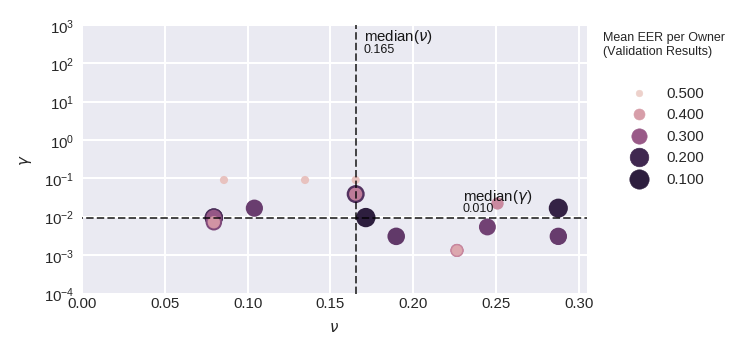

In [19]:
utils_plot_randomsearch_results(df_results, n_top=1)
utils_save_plot(plt, REPORT_PATH / f"buech2019-ocsvm-{P.name.lower()}-parameters.pdf")

**Note:** Using median to select the best parameters, as mean is strongly influenced by outliers.

In [20]:
# Clean Memory
%reset_selective -f df_

## 4. Testing <a id='4'>&nbsp;</a> 

### 4.1 Load cached Data <a id='4.1'>&nbsp;</a> 
During testing, a split with different users than used for hyperparameter optimization is used:

In [21]:
df_train_test = pd.read_msgpack(OUTPUT_PATH / "df_train_test.msg")

### 4.2 Evaluate Authentication Performance <a id='4.2'>&nbsp;</a> 

- Using Testing Split, Scenario Cross Validation, and multiple runs to lower impact of random session/sample selection.

In [22]:
df_results = None  # Will be filled with cv scores

for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + i,  # Change seed for different runs
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_train_test["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        X = X.reshape(X.shape[-3], -1)  # flatten windows
        y = df_cv_scenarios["label"].values
        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={
                "eer": utils_eer_scorer,
                "accuracy": "accuracy",
                "precision": "precision",
                "recall": "recall",
            },
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_test_results.csv", index=False)

df_results.head()

,fit_time,score_time,test_eer,train_eer,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,owner
0,0.000943,0.002655,0.402985,1.818989e-12,0.635417,0.895833,0.597015,1.0,0.833333,0.895833,973891
1,0.000932,0.002896,0.436620,1.818989e-12,0.593750,0.895833,0.563380,1.0,0.833333,0.895833,973891
2,0.001256,0.003340,0.459459,1.818989e-12,0.562500,0.895833,0.540541,1.0,0.833333,0.895833,973891
3,0.001274,0.003441,0.393939,1.818989e-12,0.645833,0.895833,0.606061,1.0,0.833333,0.895833,973891
0,0.001057,0.002823,0.443038,1.818989e-12,0.593750,0.888889,0.556962,1.0,0.916667,0.888889,171538


**Load Results from "EER & Accuracy" evaluation & prepare for plotting:**

In [23]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_test_results.csv")
df_plot = df_results.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})

**Plot Distribution of Accuracy per subject:**

Overall mean: 0.6595


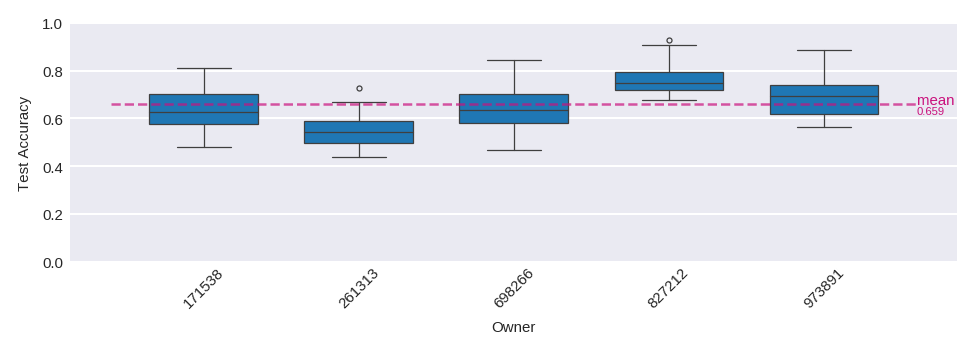

In [24]:
fig = utils_plot_acc_eer_dist(df_plot, "Test Accuracy")
utils_save_plot(plt, REPORT_PATH / f"buech2019-ocsvm-{P.name.lower()}-acc.pdf")

Overall mean: 0.3739


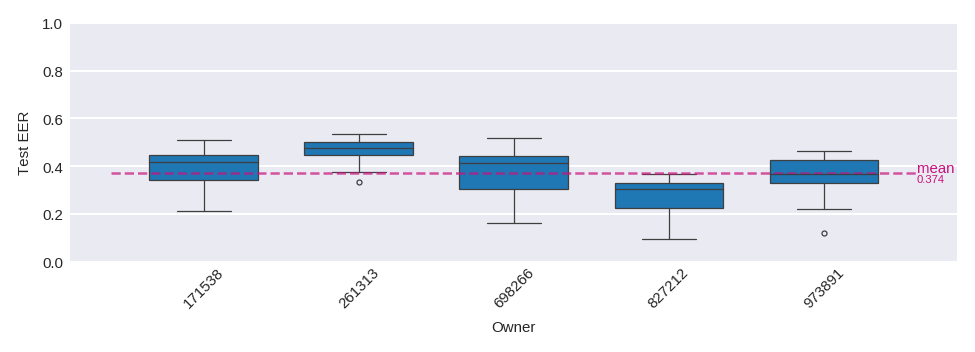

In [25]:
fig = utils_plot_acc_eer_dist(df_plot, "Test EER")
utils_save_plot(plt, REPORT_PATH / f"buech2019-ocsvm-{P.name.lower()}-eer.pdf")

### 4.3 Evaluate increasing Training Set Size (Training Delay)<a id='4.3'>&nbsp;</a> 

- Testing different amounts of samples in training set
- Using Testing Split, Scenario Cross Validation, and multiple runs to lower impact of random session/sample selection.

In [26]:
training_set_sizes = [2, 4, 6, 8, 20, 60, 120, 180, 250, 350, 500, 750]

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):
    for n_train_samples in tqdm(training_set_sizes, desc="Train Size", leave=False):
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_train_test,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                limit_train_samples=n_train_samples,  # samples overall
                seed=SEED + i,  # Change seed for different runs
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_train_test["subject"].nunique(),
            leave=False,
        ):
            X = np.array(df_cv_scenarios["X"].values.tolist())
            X = X.reshape(X.shape[-3], -1)  # flatten windows
            y = df_cv_scenarios["label"].values
            train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

            model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

            scores = cross_validate(
                model,
                X,
                y,
                cv=train_test_cv,
                scoring={"eer": utils_eer_scorer},
                n_jobs=CORES,
                verbose=0,
                return_train_score=True,
            )
            df_score = pd.DataFrame(scores)
            df_score["owner"] = owner
            df_score["train_samples"] = n_train_samples
            df_score["train_eer"] = df_score[
                "train_eer"
            ].abs()  # Revert scorer's signflip
            df_score["test_eer"] = df_score["test_eer"].abs()
            df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv", index=False)
df_results.head()

,fit_time,score_time,test_eer,train_eer,owner,train_samples
0,0.000247,0.000548,0.512195,1.818989e-12,973891,2
1,0.000287,0.000621,0.500000,1.818989e-12,973891,2
2,0.000310,0.000641,0.466667,1.818989e-12,973891,2
3,0.000329,0.000674,0.466667,1.818989e-12,973891,2
0,0.000314,0.000684,0.489362,1.818989e-12,171538,2


**Load Results from "Training set size" evaluation & prepare for plotting:**

In [27]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv")
df_plot = (
    df_results[["test_eer", "owner", "train_samples"]]
    .groupby(["owner", "train_samples"], as_index=False)
    .mean()
    .astype({"owner": "category"})
    .rename(
        columns={
            "test_eer": "Test EER",
            "owner": "Owner",
        }
    )
)
df_plot["Training Data in Seconds"] = df_plot["train_samples"] * P.window_size / P.frequency

**Plot EER with increasing number of training samples:**

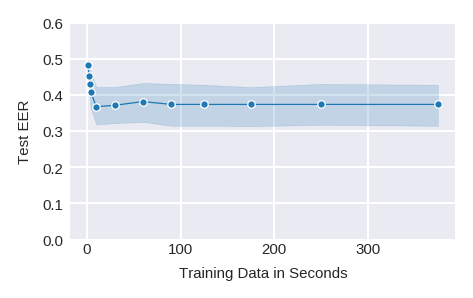

In [28]:
utils_plot_training_delay(df_plot)
utils_save_plot(plt, REPORT_PATH / f"buech2019-ocsvm-{P.name.lower()}-train-size.pdf")

### 4.4 Evaluate increasing Test Set Sizes (Detection Delay)<a id='4.4'>&nbsp;</a> 

In [29]:
df_results = None  # Will be filled with cv scores
for i in tqdm(range(20), desc="Run", leave=False):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            limit_test_samples=1,  # Samples overall
            seed=SEED + i,  # Change seed for different runs
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_train_test["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        X = X.reshape(X.shape[-3], -1)  # flatten windows
        y = df_cv_scenarios["label"].values
        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv", index=False)
df_results.head()

,fit_time,score_time,test_eer,train_eer,owner
0,0.001503,0.000924,0.5,1.818989e-12,973891
1,0.001230,0.000555,0.0,1.818989e-12,973891
2,0.001265,0.000569,0.0,1.818989e-12,973891
3,0.001296,0.000554,0.0,1.818989e-12,973891
0,0.001291,0.000551,0.0,1.818989e-12,171538


**Load Results from "Detection Delay" evaluation & prepare for plotting:**

In [30]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv")
df_results["owner"] = df_results["owner"].astype(str)
df_plot = df_results.copy()

**Plot Expanding Mean EER and confidence interval:**

Mean samples: 29.2
Mean seconds: 14.6


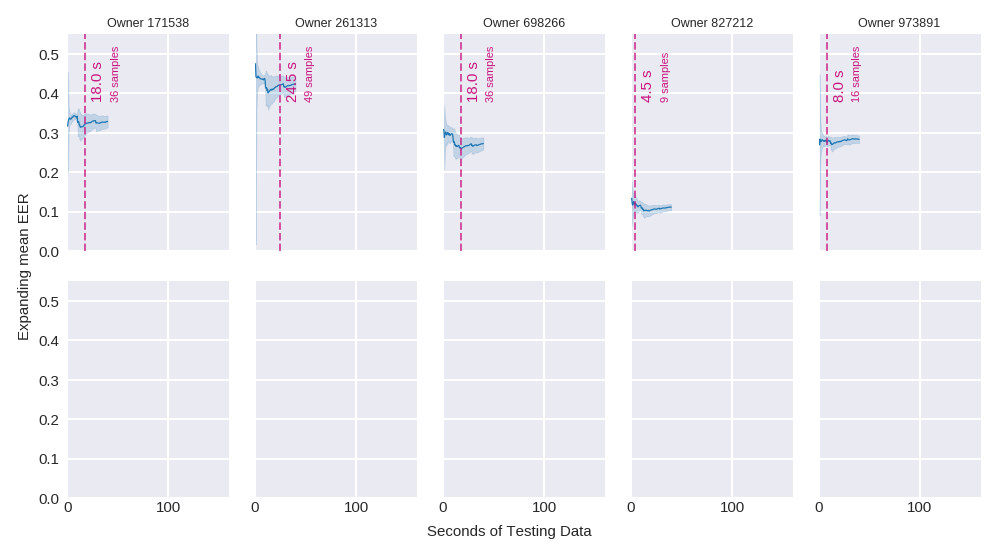

In [31]:
utils_plot_detect_delay(df_plot, factor=P.window_size / P.frequency, xlim=160)
utils_save_plot(plt, REPORT_PATH / f"buech2019-ocsvm-{P.name.lower()}-detection-delay.pdf")